# Initializations and Imports

In [16]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
! pip install nibabel
import nibabel as nib
import numpy as np
import os, glob
import psutil
import gc
import pandas as pd
import zipfile
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import seaborn as sns

from io import BytesIO


mpl.rcParams.update({
    "font.family": "Liberation Sans",   # or "Liberation Sans"
    "pdf.fonttype": 42,             # Embed TrueType fonts
    "ps.fonttype": 42,              # Prevent outline fonts
    "text.usetex": False,
    "font.size": 12,
    "axes.labelsize": 14,
    "axes.titlesize": 14,
    "savefig.dpi": 300
})

In [17]:
# changes directory from colab to gdrive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [18]:
# Choose your base folder (local runtime or Drive)
BASE_DIR = "/content/drive/MyDrive/Capstone-Project/figures"

# Create it if it doesn't exist
os.makedirs(BASE_DIR, exist_ok=True)

print(f"Figures will be saved to: {BASE_DIR}")

Figures will be saved to: /content/drive/MyDrive/Capstone-Project/figures


# Import the Tissue volume CSV

In [19]:
in_roots    = ["/content/drive/MyDrive/Capstone-Project/derivatives/pp_preproc_anat"]
in_patterns = ["**/*_preproc.nii.gz", "**/*_preproc.nii"]

seg_out_dir = "/content/drive/MyDrive/Capstone-Project/derivatives/pp_seg"

# Save volumes CSV
csv_path = os.path.join(seg_out_dir, "tissue_volumes.csv")
df_tissue=pd.read_csv(csv_path)
print("Saved:", csv_path)


Saved: /content/drive/MyDrive/Capstone-Project/derivatives/pp_seg/tissue_volumes.csv


In [20]:
# Compute total and fractions
df_tissue["Total_mm3"] = df_tissue["GM_mm3"] + df_tissue["WM_mm3"] + df_tissue["CSF_mm3"]
for t in ["GM", "WM", "CSF"]:
    df_tissue[f"{t}_frac"] = df_tissue[f"{t}_mm3"] / df_tissue["Total_mm3"]

# Feature matrix for clustering
X = df_tissue[["GM_frac", "WM_frac", "CSF_frac"]].values
X_scaled = StandardScaler().fit_transform(X)

| Column       | Meaning                                                                       |
| ------------ | ----------------------------------------------------------------------------- |
| **GM_frac**  | Fraction of total brain volume occupied by gray matter (neurons, cortex).     |
| **WM_frac**  | Fraction occupied by white matter (axons and tracts).                         |
| **CSF_frac** | Fraction occupied by cerebrospinal fluid (ventricles and surrounding spaces). |
| **Count**    | Number of subjects assigned to that cluster.                                  |


These three fractions should roughly add up to 1.0 (because GM + WM + CSF ≈ total brain volume).

# Choose optimal number of clusters for AD subclasses

In [21]:
def cluster_with_scores(
    df,
    use_features=("GM_frac","WM_frac","CSF_frac"),
    k_range=range(2, 6),
    random_state=42,
    selection_strategy="hybrid",   # "silhouette" | "bic" | "hybrid"
    delta_bic_threshold=25.0,           # how much better BIC must be to override silhouette in "hybrid"
    delta_sil_threshold=0.02,           # how much better silhouette must be to override BIC in "hybrid"
    force_k=None,                       # e.g., 3 to force k=3
    force_algo=None,                    # "kmeans" or "gmm" to force algorithm
    relabel_by_csf=True                 # reorder labels by increasing CSF fraction
):
    """
    Returns df with:
      - Cluster (float with NaNs where invalid)
      - Cluster_Prob (NaN unless GMM chosen)
      - Cluster_Model ("KMeans"/"GMM")
      - Also prints a score table for transparency.
    """
    out = df.copy()

    # Ensure features (compute fractions if needed)
    need = list(use_features)
    if not all(c in out.columns for c in need):
        mm3_cols = ["GM_mm3","WM_mm3","CSF_mm3"]
        if all(c in out.columns for c in mm3_cols):
            total = out[mm3_cols].sum(axis=1)
            out["GM_frac"]  = out["GM_mm3"]  / total
            out["WM_frac"]  = out["WM_mm3"]  / total
            out["CSF_frac"] = out["CSF_mm3"] / total
        else:
            raise ValueError("Provide GM/WM/CSF fractions or mm3 columns.")

    X = out[list(use_features)].astype(float)
    valid_mask = np.isfinite(X).all(axis=1)
    X_valid = X[valid_mask].values
    if X_valid.shape[0] < 5:
        raise ValueError("Not enough valid rows to cluster (need >=5).")

    scaler = StandardScaler()
    Xs = scaler.fit_transform(X_valid)

    # To store scores
    rows = []

    # KMeans grid (silhouette)
    for k in k_range:
        try:
            km = KMeans(n_clusters=k, n_init=50, random_state=random_state)
            km_labels = km.fit_predict(Xs)
            if len(np.unique(km_labels)) < 2:
                sil = np.nan
            else:
                sil = silhouette_score(Xs, km_labels)
            rows.append({"algo":"KMeans", "k":k, "silhouette":sil, "bic":np.nan, "model":km, "labels":km_labels, "proba":None})
        except Exception:
            rows.append({"algo":"KMeans", "k":k, "silhouette":np.nan, "bic":np.nan, "model":None, "labels":None, "proba":None})

    # GMM grid (BIC + silhouette)
    for k in k_range:
        try:
            gmm = GaussianMixture(n_components=k, covariance_type='full', n_init=10, random_state=random_state)
            gmm.fit(Xs)
            labels = gmm.predict(Xs)
            bic = gmm.bic(Xs)
            sil = silhouette_score(Xs, labels) if len(np.unique(labels)) > 1 else np.nan
            rows.append({"algo":"GMM", "k":k, "silhouette":sil, "bic":bic, "model":gmm, "labels":labels, "proba":gmm.predict_proba(Xs)})
        except Exception:
            rows.append({"algo":"GMM", "k":k, "silhouette":np.nan, "bic":np.nan, "model":None, "labels":None, "proba":None})

    score_df = pd.DataFrame(rows)
    # Pretty print summary
    with pd.option_context('display.float_format', '{:.3f}'.format):
        print("\n=== Clustering model scores ===")
        print(score_df.sort_values(["algo","k"])[["algo","k","silhouette","bic"]])

    # Apply forcing if requested
    cand = score_df.dropna(subset=["labels"]).copy()
    if force_k is not None:
        cand = cand[cand["k"] == force_k]
        if cand.empty:
            raise RuntimeError(f"No successful models for forced k={force_k}.")
    if force_algo is not None:
        cand = cand[cand["algo"].str.lower() == force_algo.lower()]
        if cand.empty:
            raise RuntimeError(f"No successful models for forced algo={force_algo}.")

    if cand.empty:
        raise RuntimeError("No successful clustering models.")

    # Selection strategies
    if selection_strategy == "silhouette":
        # pick max silhouette
        winner = cand.loc[cand["silhouette"].idxmax()]
    elif selection_strategy == "bic":
        # pick min BIC among GMM only
        gmm_only = cand[cand["algo"]=="GMM"].dropna(subset=["bic"])
        if gmm_only.empty:
            # fallback to silhouette if no GMM
            winner = cand.loc[cand["silhouette"].idxmax()]
        else:
            winner = gmm_only.loc[gmm_only["bic"].idxmin()]
    else:
        # hybrid: if best GMM BIC beats others by delta_bic_threshold, choose it,
        # else choose best silhouette; allow silhouette to override if >= delta_sil_threshold better
        # Best GMM by BIC:
        gmm_only = cand[cand["algo"]=="GMM"].dropna(subset=["bic"])
        best_bic_row = gmm_only.loc[gmm_only["bic"].idxmin()] if not gmm_only.empty else None
        # Best overall silhouette:
        best_sil_row = cand.loc[cand["silhouette"].idxmax()] if cand["silhouette"].notna().any() else None

        if best_bic_row is not None and best_sil_row is not None and np.isfinite(best_sil_row["silhouette"]):
            # Check if GMM’s BIC advantage is “big enough”
            # We compare BIC across GMMs only; to judge "big enough", compare to median BIC
            bic_advantage = (gmm_only["bic"].median() - best_bic_row["bic"]) if "bic" in gmm_only else 0.0
            sil_diff = (best_sil_row["silhouette"] - (best_bic_row["silhouette"] if np.isfinite(best_bic_row["silhouette"]) else -np.inf))
            if bic_advantage >= delta_bic_threshold and sil_diff < delta_sil_threshold:
                winner = best_bic_row
            else:
                winner = best_sil_row
        else:
            # fallback to whichever exists
            winner = best_bic_row if best_bic_row is not None else best_sil_row

    # Build full-length label/prob arrays
    labels_full = np.full(len(out), np.nan)
    probs_full  = np.full(len(out), np.nan)
    labels_sel  = winner["labels"]
    labels_full[valid_mask] = labels_sel

    if winner["algo"] == "GMM" and winner["proba"] is not None:
        probs_full[valid_mask] = winner["proba"].max(axis=1)

    # Optional: relabel clusters by increasing CSF fraction for interpretability
    if relabel_by_csf:
        tmp = out.loc[valid_mask, list(use_features)].copy()
        tmp["label"] = labels_full[valid_mask].astype(int)
        # guard: ensure CSF_frac exists in features
        if "CSF_frac" in tmp.columns and tmp["label"].notna().any():
            csf_means = tmp.groupby("label")["CSF_frac"].mean().sort_values().index.tolist()
            relabel_map = {old: new for new, old in enumerate(csf_means)}
            labels_full = np.array([relabel_map[int(l)] if np.isfinite(l) else np.nan for l in labels_full], dtype=float)

    out["Cluster"] = labels_full
    out["Cluster_Prob"] = probs_full if winner["algo"] == "GMM" else np.nan
    out["Cluster_Model"] = winner["algo"]
    out.attrs["cluster_scores"] = score_df  # keep for later inspection if you want

    print(f"\nChosen: {winner['algo']} (k={int(winner['k'])}) | silhouette={winner['silhouette']:.3f} | "
          f"BIC={winner['bic'] if np.isfinite(winner['bic']) else np.nan}")

    return out


In [22]:
# ---------- EXAMPLES ----------
# 1) Match your earlier behavior: prioritize silhouette (often KMeans k=3)
df_tissue = cluster_with_scores(
    df_tissue,
    selection_strategy="silhouette",
    k_range=range(2, 6),
    random_state=42
)

# 2) If you specifically want KMeans k=3 (exact comparability):
# df_tissue = cluster_with_scores(df_tissue, selection_strategy="silhouette", force_k=4, force_algo="kmeans")

# 3) If you want the original “robust hybrid” but with explicit margins:
# df_tissue = cluster_with_scores(df_tissue, selection_strategy="hybrid", delta_bic_threshold=25.0, delta_sil_threshold=0.02)

df_tissue = cluster_with_scores(df_tissue, selection_strategy="silhouette", k_range=range(2, 6), random_state=42)

score_df = df_tissue.attrs["cluster_scores"].copy()


=== Clustering model scores ===
     algo  k  silhouette      bic
4     GMM  2       0.368 -609.788
5     GMM  3       0.345 -572.506
6     GMM  4       0.366 -528.677
7     GMM  5       0.322 -493.783
0  KMeans  2       0.373      NaN
1  KMeans  3       0.358      NaN
2  KMeans  4       0.375      NaN
3  KMeans  5       0.355      NaN

Chosen: KMeans (k=4) | silhouette=0.375 | BIC=nan

=== Clustering model scores ===
     algo  k  silhouette      bic
4     GMM  2       0.368 -609.788
5     GMM  3       0.345 -572.506
6     GMM  4       0.366 -528.677
7     GMM  5       0.322 -493.783
0  KMeans  2       0.373      NaN
1  KMeans  3       0.358      NaN
2  KMeans  4       0.375      NaN
3  KMeans  5       0.355      NaN

Chosen: KMeans (k=4) | silhouette=0.375 | BIC=nan


# 3D Clustering of Brain Tissue Composition

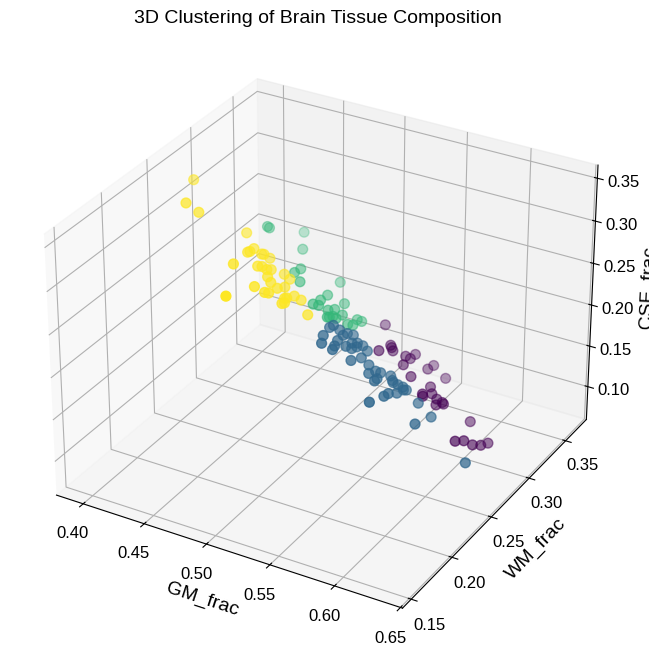

In [23]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(df_tissue["GM_frac"], df_tissue["WM_frac"], df_tissue["CSF_frac"], c=df_tissue["Cluster"], cmap="viridis", s=50)
ax.set_xlabel("GM_frac"); ax.set_ylabel("WM_frac"); ax.set_zlabel("CSF_frac")
plt.title("3D Clustering of Brain Tissue Composition")
# save_path = os.path.join(BASE_DIR, "3d_clus_brain_tissue.pdf")
# plt.savefig(save_path, bbox_inches="tight")
plt.show()


In [24]:
summary = df_tissue.groupby("Cluster")[["GM_frac", "WM_frac", "CSF_frac"]].mean()
summary["Count"] = df_tissue["Cluster"].value_counts().sort_index().values
print(summary)


          GM_frac   WM_frac  CSF_frac  Count
Cluster                                     
0.0      0.567392  0.306314  0.126294     27
1.0      0.555572  0.250845  0.193584     41
2.0      0.489037  0.294303  0.216660     24
3.0      0.476493  0.240762  0.282745     32


# Tissue Composition by Cluster/Sub-group

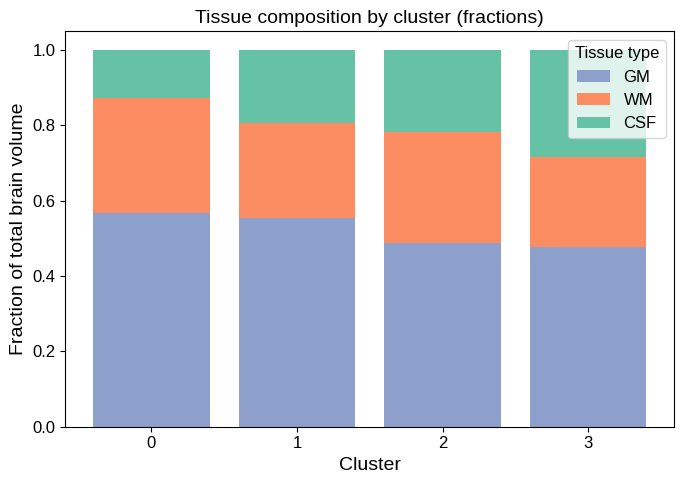

In [25]:
summary = df_tissue.groupby("Cluster")[["GM_frac", "WM_frac", "CSF_frac"]].mean()
summary["Count"] = df_tissue["Cluster"].value_counts().sort_index().values
summary = summary.reset_index()

plt.figure(figsize=(7,5))
bottom = np.zeros(len(summary))
colors = ["#8da0cb","#fc8d62","#66c2a5"]
for frac, col, name in zip(["GM_frac","WM_frac","CSF_frac"], colors, ["GM","WM","CSF"]):
    plt.bar(summary["Cluster"], summary[frac], bottom=bottom, color=col, label=name)
    bottom += summary[frac]
plt.xticks(summary["Cluster"])
plt.ylabel("Fraction of total brain volume")
plt.xlabel("Cluster")
plt.title("Tissue composition by cluster (fractions)")
plt.legend(title="Tissue type")
plt.tight_layout()
# save_path = os.path.join(BASE_DIR, "tissue_comp_cluster_stackedbar.pdf")
# plt.savefig(save_path, bbox_inches="tight")
plt.show()


# Pairwise Tissue fraction relationship

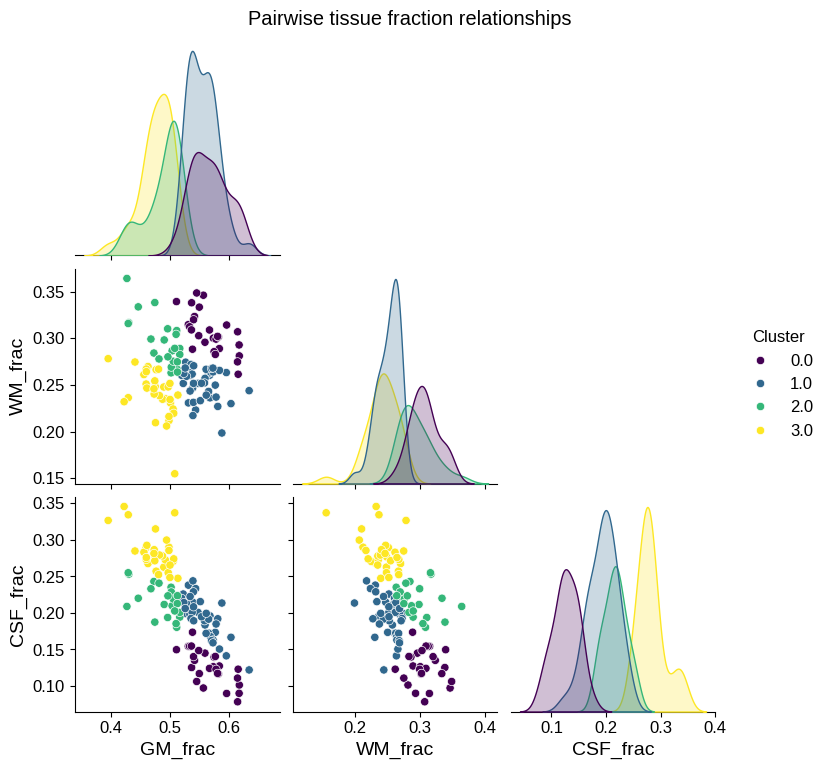

In [26]:
sns.pairplot(df_tissue, vars=["GM_frac","WM_frac","CSF_frac"], hue="Cluster", palette="viridis", corner=True)
plt.suptitle("Pairwise tissue fraction relationships", y=1.02)

# save_path = os.path.join(BASE_DIR, "pairwise_tissue_frac.pdf")
# plt.savefig(save_path, bbox_inches="tight")
plt.show()


# PCA on tissue composition

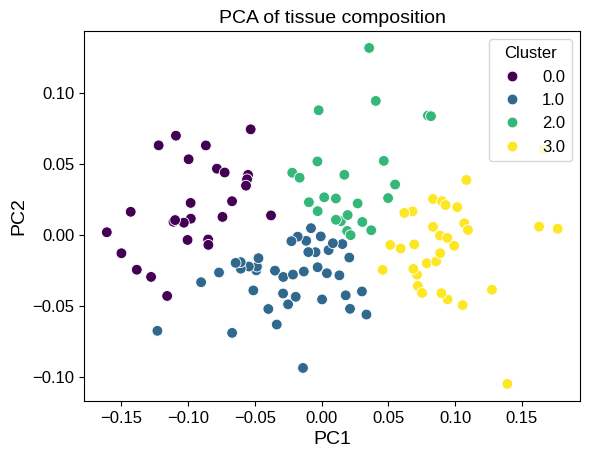

Explained variance ratios: [0.78731888 0.21268112]


In [27]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(df_tissue[["GM_frac","WM_frac","CSF_frac"]])
df_tissue["PC1"], df_tissue["PC2"] = X_pca[:,0], X_pca[:,1]

sns.scatterplot(data=df_tissue, x="PC1", y="PC2", hue="Cluster", palette="viridis", s=60)
plt.title("PCA of tissue composition")

# save_path = os.path.join(BASE_DIR, "pca_tissue_comp.pdf")
# plt.savefig(save_path, bbox_inches="tight")
plt.show()

print("Explained variance ratios:", pca.explained_variance_ratio_)


Observation :  “If PC1 captures >70%, that component likely reflects GM–CSF trade-off”

The largest source of variation in your data is how gray matter decreases while CSF increases across subjects.

That’s the dominant anatomical pattern distinguishing your clusters — consistent with AD → MCI → CN continuum.

In [28]:
X_scaled = StandardScaler().fit_transform(df_tissue[["GM_frac","WM_frac","CSF_frac"]])
sil = silhouette_score(X_scaled, df_tissue["Cluster"])
print(f"Silhouette score: {sil:.3f}")


Silhouette score: 0.375


Observation : Moderate separability

The progressive decrease in GM and WM with a rise in CSF across clusters (0 → 3) reflects a neurodegenerative gradient.

This mirrors the continuum:

Cluster 0 → CN → Cluster 1 → MCI → Cluster 2 → early AD → Cluster 3 → advanced AD

Even though this was unsupervised, the structure emerging is biologically aligned with Alzheimer’s trajectories:

GM loss = cortical atrophy

CSF increase = ventricular enlargement

WM decline = reduced structural connectivity

# GM-CSF trade-off across clusters

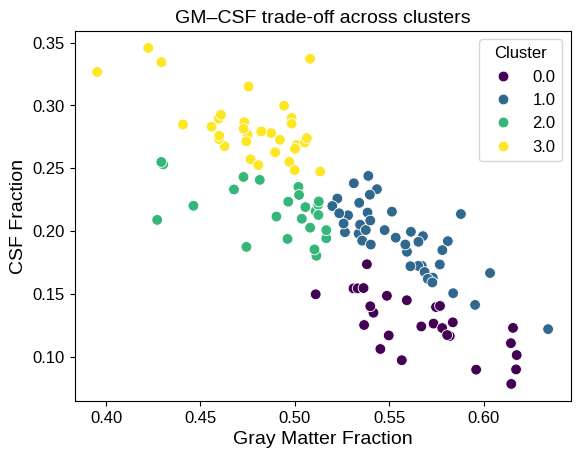

In [29]:
sns.scatterplot(data=df_tissue, x="GM_frac", y="CSF_frac", hue="Cluster", palette="viridis", s=60)
plt.title("GM–CSF trade-off across clusters")
plt.xlabel("Gray Matter Fraction")
plt.ylabel("CSF Fraction")

# save_path = os.path.join(BASE_DIR, "csf_gm_scatter.pdf")
# plt.savefig(save_path, bbox_inches="tight")
plt.show()


# Save output CSV

In [30]:
seg_out_dir = "/content/drive/MyDrive/Capstone-Project/derivatives/pp_seg"
os.makedirs(seg_out_dir, exist_ok=True)

# Save volumes CSV
csv_path = os.path.join(seg_out_dir, "tissue_volumes_w_cluster_seg.csv")
df_tissue.to_csv(csv_path, index=False)
print("Saved:", csv_path)

Saved: /content/drive/MyDrive/Capstone-Project/derivatives/pp_seg/tissue_volumes_w_cluster_seg.csv
